In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from autoviz.AutoViz_Class import AutoViz_Class

In [8]:
AV=AutoViz_Class

In [9]:
data = pd.read_excel("CocaCola_Sales_Rawdata.xlsx")
data.head()

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996


In [10]:
data.tail()

,Quarter,Sales
37,Q2_95,4936.0
38,Q3_95,4895.0
39,Q4_95,4333.0
40,Q1_96,4194.0
41,Q2_96,5253.0


In [11]:
data.shape

(42, 2)

In [14]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Sales,42.0,2994.353308,977.930896,1547.818996,2159.714247,2782.376999,3609.25,5253.0


In [15]:
data.nunique()

Quarter    42
Sales      42
dtype: int64

In [16]:
quarter=['Q1','Q2','Q3','Q4']
n=data['Quarter'][0]
data['quarter']=0

for i in range(42):
    n=data['Quarter'][i]
    data['quarter'][i]=n[0:2]

In [17]:
data.head()

,Quarter,Sales,quarter
0,Q1_86,1734.827000,Q1
1,Q2_86,2244.960999,Q2
2,Q3_86,2533.804993,Q3
3,Q4_86,2154.962997,Q4
4,Q1_87,1547.818996,Q1


In [18]:
# Visualization
filename = "CocaCola_Sales_Rawdata.xlsx"
sep = ","
dft = AV.AutoViz(
    filename,
    sep=",",
    depVar="",
    dfte=None,
    header=0,
    verbose=0,
    lowess=False,
    chart_format="svg",
    max_rows_analyzed=150000,
    max_cols_analyzed=30,
)

TypeError: AutoViz() missing 1 required positional argument: 'filename'

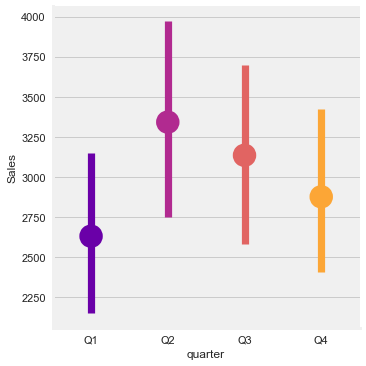

In [19]:
sns.factorplot(data = data, x = 'quarter', y = "Sales", palette = 'plasma')

In [20]:
dummy=pd.DataFrame(pd.get_dummies(data['quarter']))
dummy.head()

,Q1,Q2,Q3,Q4
0,1,0,0,0
1,0,1,0,0
2,0,0,1,0
3,0,0,0,1
4,1,0,0,0


In [21]:
data_new=pd.concat((data,dummy),axis=1)
t= np.arange(1,43)
data_new['t']=t
data_new['t_square']=data_new['t']*data_new['t']

In [22]:
log_Sales=np.log(data_new['Sales'])
data_new['log_Sales']=log_Sales


<AxesSubplot:>

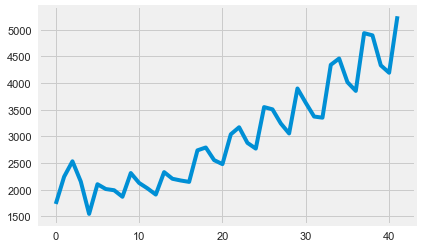

In [23]:
train= data_new.head(38)
test=data_new.tail(4)
data_new.Sales.plot()

In [25]:
# linear model
import statsmodels.formula.api as smf
import statsmodels.api as sm
#linear model
linear= smf.ols('Sales~t',data=train).fit()
predlin=pd.Series(linear.predict(pd.DataFrame(test['t'])))
rmselin=np.sqrt((np.mean(np.array(test['Sales'])-np.array(predlin))**2))
print(rmselin)

421.17878760022745


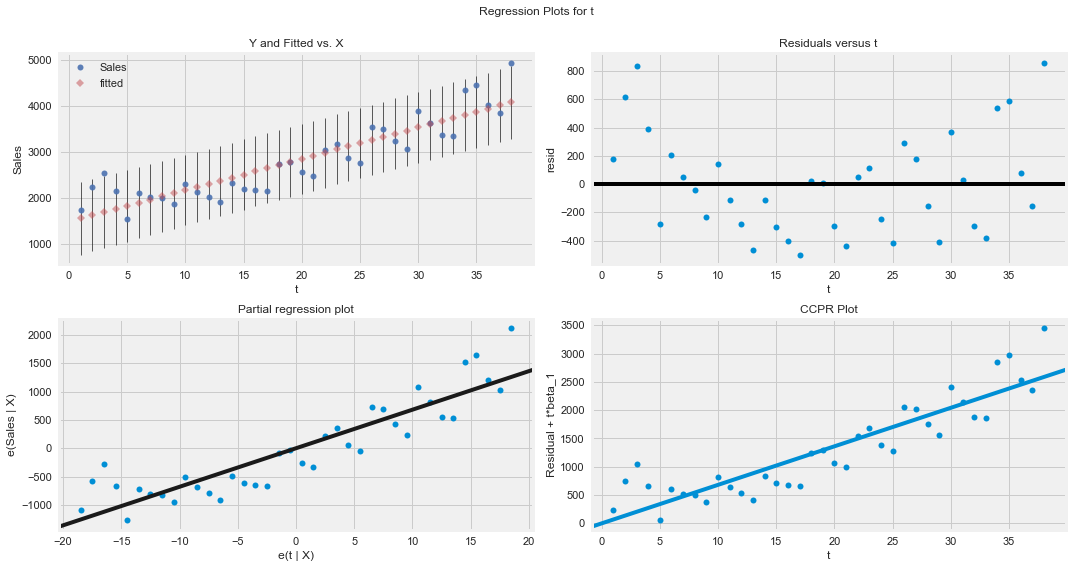

In [26]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(linear, "t", fig=fig)

In [27]:
# Quadratic model
quad=smf.ols('Sales~t+t_square',data=train).fit()
predquad=pd.Series(quad.predict(pd.DataFrame(test[['t','t_square']])))
rmsequad=np.sqrt(np.mean((np.array(test['Sales'])-np.array(predquad))**2))
rmsequad

475.5618351831504

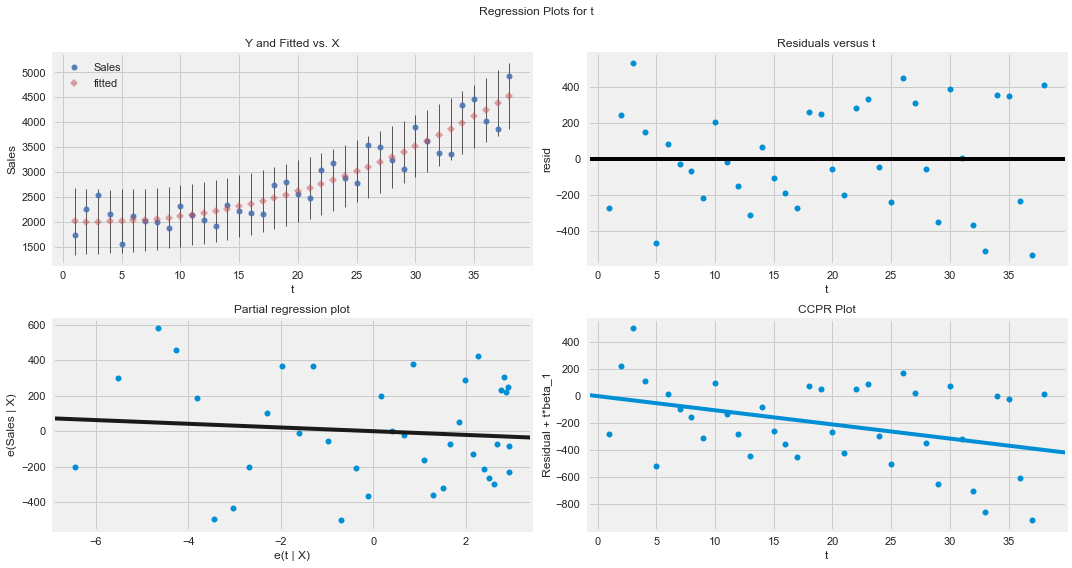

In [28]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(quad, "t", fig=fig)

In [29]:
# Additive seasonality
additive= smf.ols('Sales~ Q1+Q2+Q3+Q4',data=train).fit()
predadd=pd.Series(additive.predict(pd.DataFrame(test[['Q1','Q2','Q3','Q4']])))
predadd
rmseadd=np.sqrt(np.mean((np.array(test['Sales'])-np.array(predadd))**2))
rmseadd

1860.0238154547274

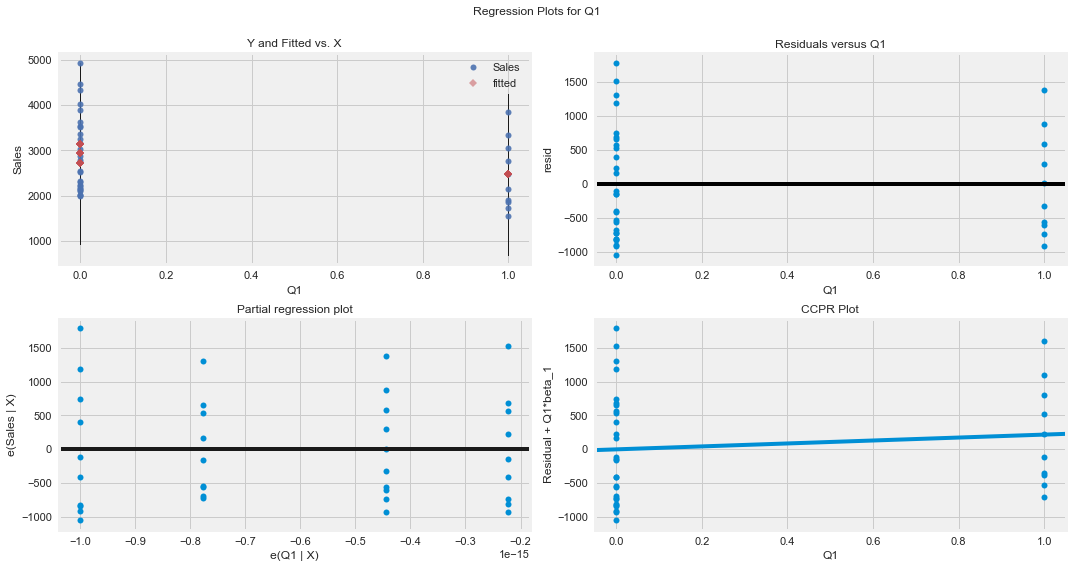

In [30]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(additive,exog_idx=1,fig=fig)

In [31]:
# Additive seasonality with linear trend
addlinear= smf.ols('Sales~t+Q1+Q2+Q3+Q4',data=train).fit()
predaddlinear=pd.Series(addlinear.predict(pd.DataFrame(test[['t','Q1','Q2','Q3','Q4']])))
predaddlinear

38    4292.265126
39    4066.761792
40    3961.769195
41    4639.214094
dtype: float64

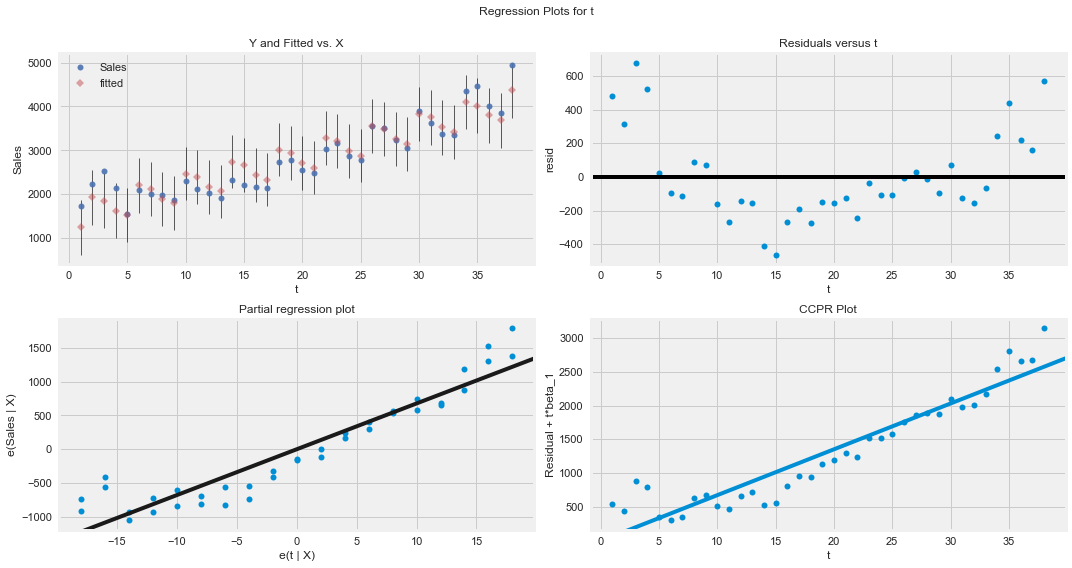

In [32]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(addlinear, exog_idx=1, fig=fig)

In [33]:
rmseaddlinear=np.sqrt(np.mean((np.array(test['Sales'])-np.array(predaddlinear))**2))
rmseaddlinear

464.9829023982257

In [34]:
# Additive seasonality with quadratic trend
addquad=smf.ols('Sales~t+t_square+Q1+Q2+Q3+Q4',data=train).fit()
predaddquad=pd.Series(addquad.predict(pd.DataFrame(test[['t','t_square','Q1','Q2','Q3','Q4']])))
rmseaddquad=np.sqrt(np.mean((np.array(test['Sales'])-np.array(predaddquad))**2))
rmseaddquad

301.73800719347435

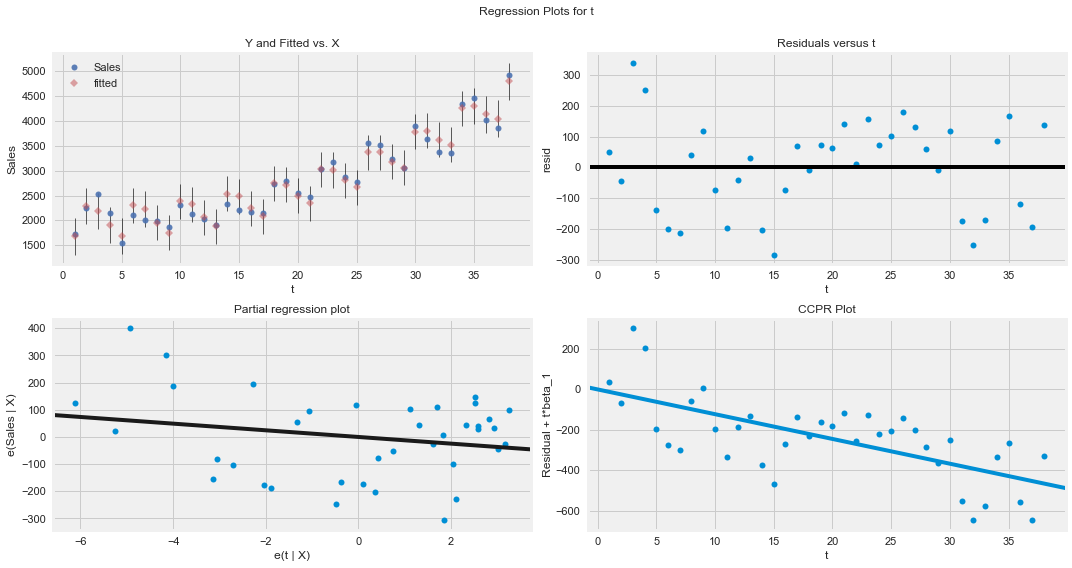

In [35]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(addquad, exog_idx=1, fig=fig)

In [36]:
# Multiplicative seasonality
mulsea=smf.ols('log_Sales~Q1+Q2+Q3+Q4',data=train).fit()
predmul= pd.Series(mulsea.predict(pd.DataFrame(test[['Q1','Q2','Q3','Q4']])))
rmsemul= np.sqrt(np.mean((np.array(test['Sales'])-np.array(np.exp(predmul)))**2))
rmsemul

1963.3896400779681

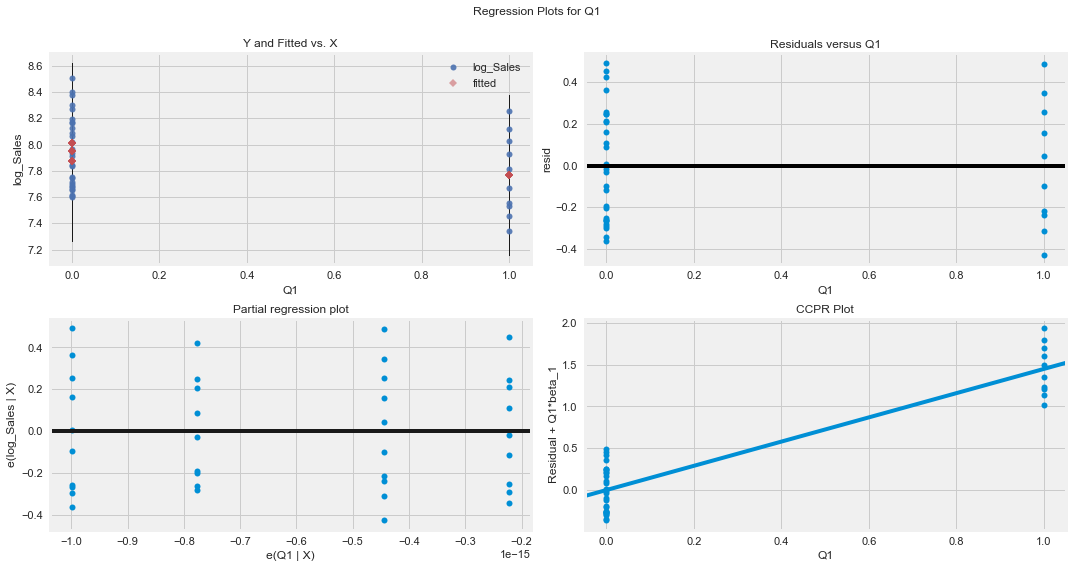

In [37]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(mulsea, exog_idx=1, fig=fig)

In [38]:
# Multiplicative seasonality with linear trend
mullin= smf.ols('log_Sales~t+Q1+Q2+Q3+Q4',data=train).fit()
predmullin= pd.Series(mullin.predict(pd.DataFrame(test[['t','Q1','Q2','Q3','Q4']])))
rmsemulin=np.sqrt(np.mean((np.array(test['Sales'])-np.array(np.exp(predmullin)))**2))
rmsemulin

225.52439049828402

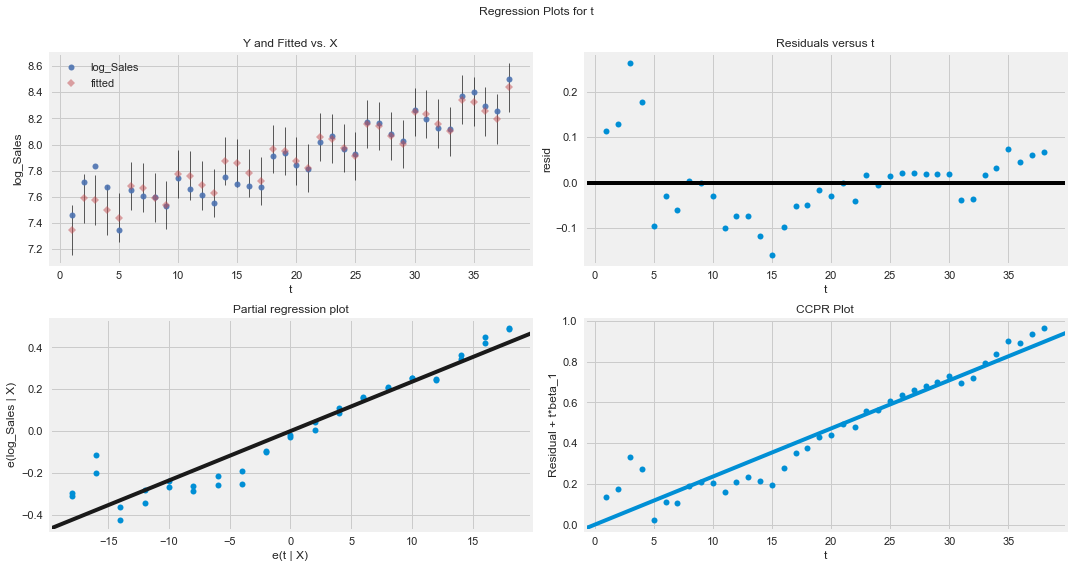

In [39]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(mullin, exog_idx=1, fig=fig)

In [40]:
# Multiplicative seasonality with quadratic trend
mul_quad= smf.ols('log_Sales~t+t_square+Q1+Q2+Q3+Q4',data=train).fit()
pred_mul_quad= pd.Series(mul_quad.predict(test[['t','t_square','Q1','Q2','Q3','Q4']]))
rmse_mul_quad=np.sqrt(np.mean((np.array(test['Sales'])-np.array(np.exp(pred_mul_quad)))**2))
rmse_mul_quad

581.8457187958758

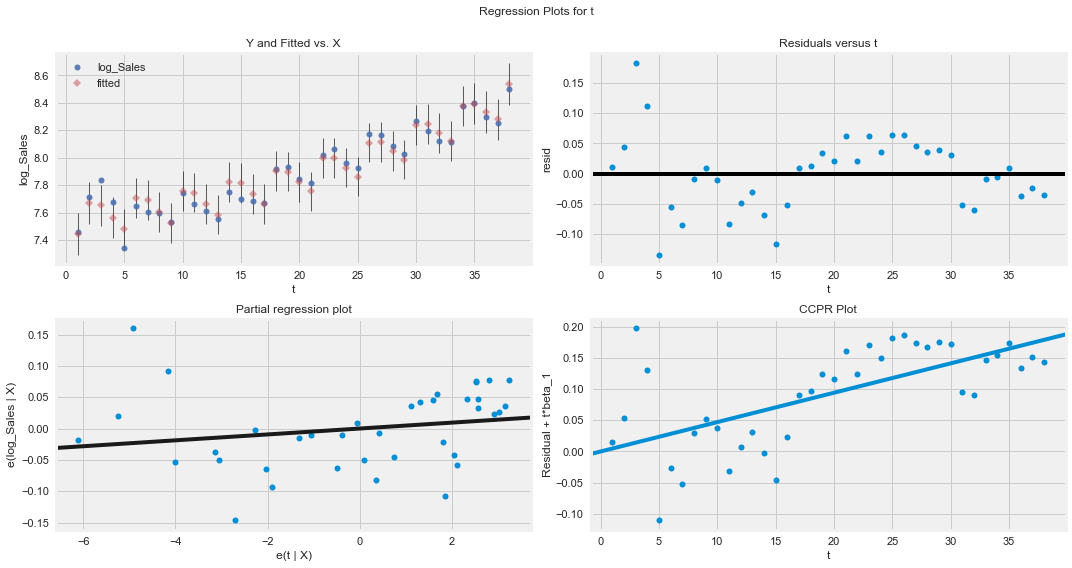

In [41]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(mul_quad, exog_idx=1, fig=fig)

In [42]:
# Exponential model
expo=smf.ols('log_Sales~t',data=train).fit()
predexp=pd.Series(expo.predict(pd.DataFrame(test['t'])))
predexp
rmseexpo=np.sqrt(np.mean((np.array(test['Sales'])-np.array(np.exp(predexp)))**2))
rmseexpo

466.2479731067161

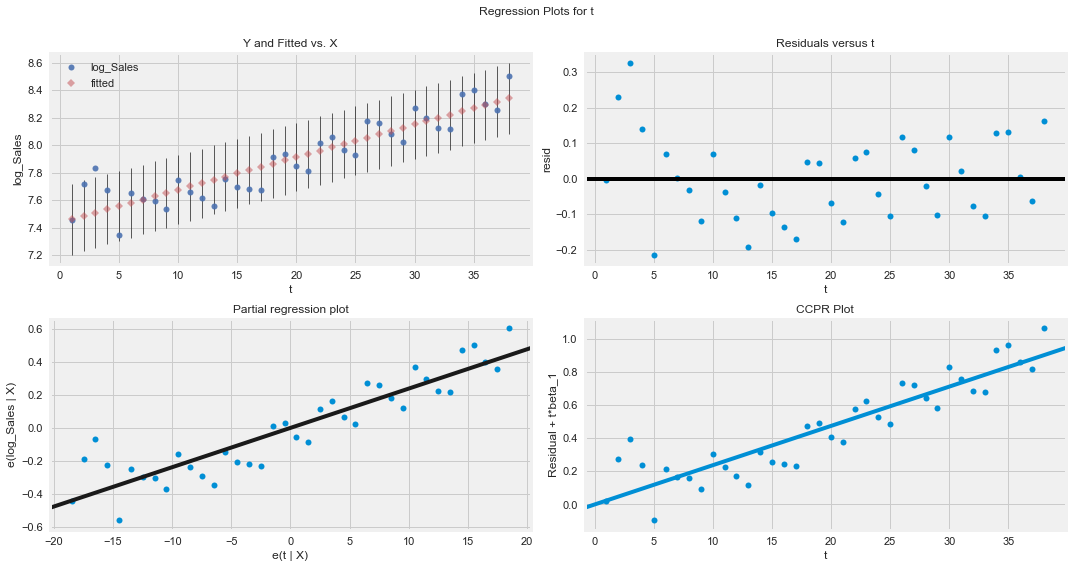

In [43]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(expo, exog_idx=1, fig=fig)

In [44]:
# MODEL VALUES
salesdata={'Model':pd.Series(['rmse_mul_quad','rmseadd','rmseaddlinear','rmseaddquad','rmseexpo','rmselin','rmsemul','rmsemulin','rmsequad']),'Values':pd.Series([rmse_mul_quad,rmseadd,rmseaddlinear,rmseaddquad,rmseexpo,rmselin,rmsemul,rmsemulin,rmsequad])}
salesdata

Rmse=pd.DataFrame(salesdata)
Rmse

,Model,Values
0,rmse_mul_quad,581.845719
1,rmseadd,1860.023815
2,rmseaddlinear,464.982902
3,rmseaddquad,301.738007
4,rmseexpo,466.247973
5,rmselin,421.178788
6,rmsemul,1963.389640
7,rmsemulin,225.524390
8,rmsequad,475.561835
